
0: 480x640 24 objects, 186.6ms
Speed: 2.5ms preprocess, 186.6ms inference, 571.5ms postprocess per image at shape (1, 3, 480, 640)
Skipping segment 0 due to size constraints
Skipping segment 1 due to size constraints
Skipping segment 2 due to size constraints
Skipping segment 3 due to size constraints
Skipping segment 4 due to size constraints
Skipping segment 5 due to size constraints
Skipping segment 6 due to size constraints
Skipping segment 7 due to size constraints


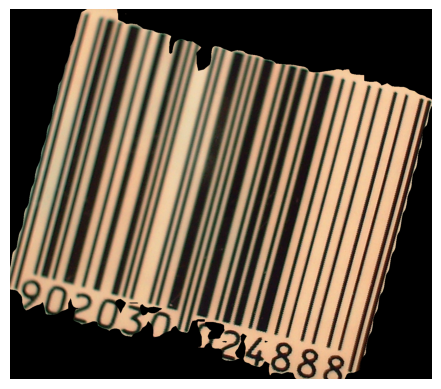

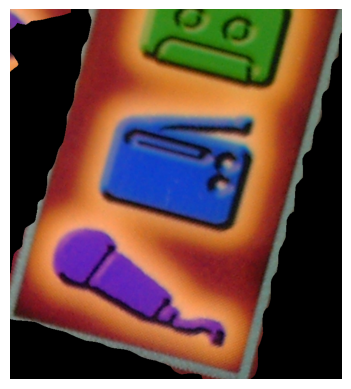

Skipping segment 10 due to size constraints


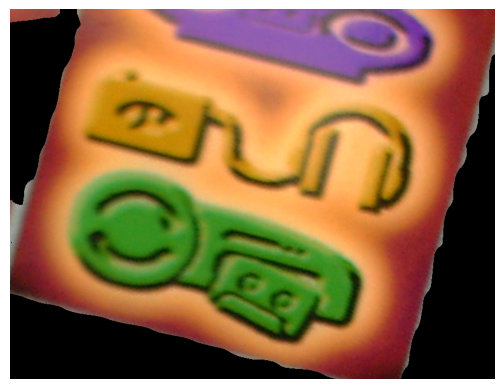

Skipping segment 12 due to size constraints
Skipping segment 13 due to size constraints
Skipping segment 14 due to size constraints
Skipping segment 15 due to size constraints
Skipping segment 16 due to size constraints
Skipping segment 17 due to size constraints


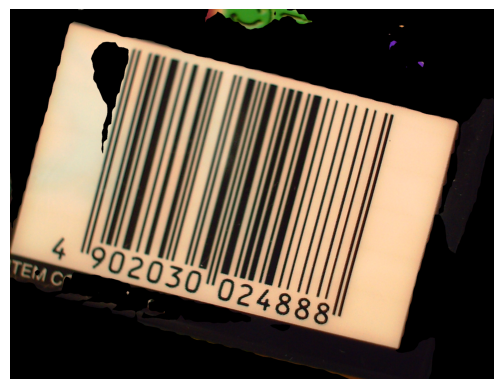

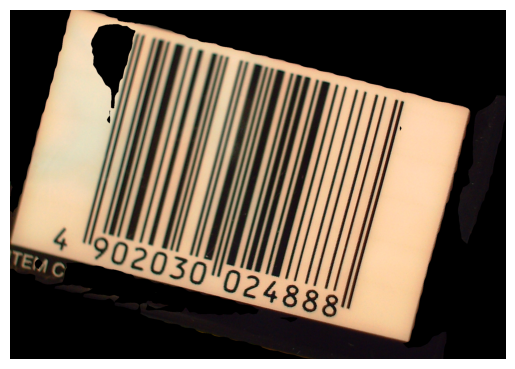

Skipping segment 20 due to size constraints
Skipping segment 21 due to size constraints
Skipping segment 22 due to size constraints
Skipping segment 23 due to size constraints


In [121]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from ultralytics import FastSAM
from scipy import stats
import matplotlib.pyplot as plt


def check(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ddepth = cv2.CV_32F 
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    blurred = cv2.blur(gradient, (9, 9))
    _, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)
    cnts, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return 0
    c = max(cnts, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int32(box) 
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    return 1


def extract_segments(image_path):
    output_dir = "./segments"
    os.makedirs(output_dir, exist_ok=True)
    model = FastSAM('FastSAM-s.pt')
    original_image = Image.open(image_path)
    image_np = np.array(original_image)
    image_area = original_image.size[0] * original_image.size[1]
    results = model(original_image, device='cuda' if torch.cuda.is_available() else 'cpu',
                    retina_masks=True, conf=0.4, iou=0.9)
    annotations = results[0].masks.data
    if annotations is None:
        print("No segments detected")
        return []
    segments = []
    for idx, annotation in enumerate(annotations):
        mask = annotation.cpu().numpy()
        mask = cv2.resize(mask, (original_image.size[0], original_image.size[1]))
        mask = mask > 0.5
        segment = np.zeros_like(image_np)
        
        segment[mask] = image_np[mask]
        
        y_indices, x_indices = np.where(mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            bbox_area = (x_max - x_min + 1) * (y_max - y_min + 1)
            if bbox_area < 0.05 * image_area or bbox_area > 0.9 * image_area:
                print(f"Skipping segment {idx} due to size constraints")
                continue
    
            cropped_segment = segment[y_min:y_max+1, x_min:x_max+1]
            if(check(cropped_segment)==0):
                print(f"Skipping segment {idx} due to segmenation problem")
                continue
            cv2.imwrite(f"{output_dir}/segment_{idx}.png", cv2.cvtColor(cropped_segment, cv2.COLOR_RGB2BGR))
            segments.append({'index': idx, 'mask': mask, 'cropped_segment': cropped_segment})
    
    return segments

def main():
    image_path = "BarcodeDatasets/Dataset1/PICT0020.JPG"
    
    try:
        segments = extract_segments(image_path)

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
import zxing

image_path = "segments/segment_0.png"  
reader = zxing.BarCodeReader()
barcode = reader.decode(image_path)
if barcode:
    print("Type:", barcode.format)
    print("Data:", barcode.raw)
else:
    print("No barcode detected.")


Type: EAN_13
Data: 4902030187590


Checking if diagonal decoding works

Mean of angles is:  18.869566
Detected angle: 378.8695659637451


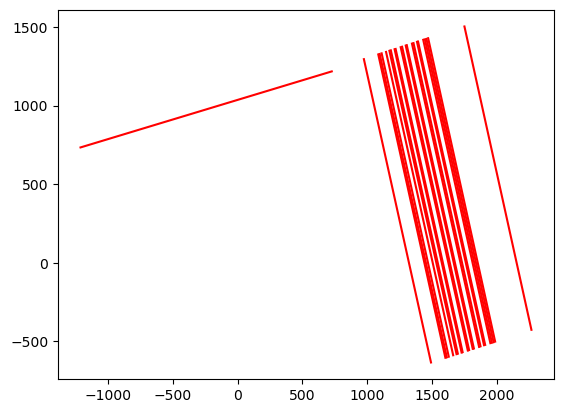

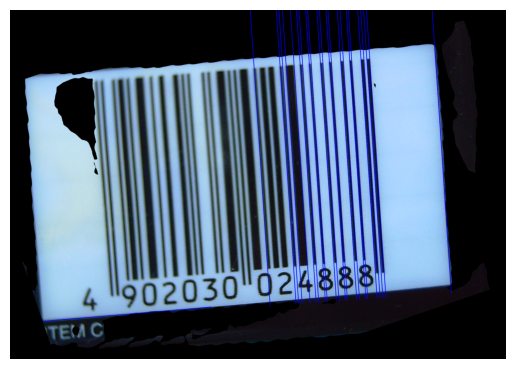

Type: EAN_13
Data: 4902030024888


In [122]:
def check_horizontal(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 300)

    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            plt.plot((x1, x2), (y1, y2), 'r')
        angles = [np.degrees(theta) for rho, theta in lines[:, 0]]
        
        print("Mean of angles is: ", np.mean(angles))
        if(abs(np.mean(angles) - 90) < 5 or abs(np.mean(angles) - 270) < 5):
            
            plt.figure()
            plt.imshow(img)
            plt.axis("off")
            plt.show()
            return img
        else:
            angle = np.mean(angles) + 180  
            if(np.mean(angles) < 90):
                angle = angle + 180
        print(f"Detected angle: {angle}")

        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_img = cv2.warpAffine(img, M, (w, h))
    else:
        print("No rotation detected")
        rotated_img = img  

    plt.figure()
    plt.imshow(rotated_img)
    plt.axis("off")
    plt.show()

    return rotated_img

image_path = "segments/segment_19.png"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rotated_img = check_horizontal(img)

os.makedirs("rotated_segments", exist_ok=True)
cv2.imwrite("rotated_segments/rotated_segment.png", cv2.cvtColor(rotated_img, cv2.COLOR_RGB2BGR))

rotated_path = "rotated_segments/rotated_segment.png"

barcode1 = reader.decode(rotated_path)
if barcode1:
    print("Type:", barcode1.format)
    print("Data:", barcode1.raw)
else:
    print("No barcode detected.")

In [124]:
def barcode_reader(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found or unable to read.")
    
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    
    binary = cv2.bitwise_not(binary)
    
    row_sums = np.sum(binary, axis=0)
    threshold = 0.5 * np.max(row_sums)
    barcode_signal = (row_sums > threshold).astype(int)
    
    bars = []
    current_width = 0
    for bit in barcode_signal:
        if bit == 1:
            current_width += 1
        elif current_width > 0:
            bars.append(current_width)
            current_width = 0
    if current_width > 0:
        bars.append(current_width)
    min_width = min(bars)
    normalized_bars = [round(bar / min_width) for bar in bars]
    print(f"Raw Bar Widths: {normalized_bars}")
    ean13_code = ''.join(map(str, normalized_bars))
    print(f"EAN-13 Code: {ean13_code}")
    
barcode_reader(rotated_path)

Raw Bar Widths: [122, 45, 38, 1, 192, 164, 473, 19, 32, 23, 7, 36, 81, 298]
EAN-13 Code: 1224538119216447319322373681298
